In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numbers
import datetime
pd.options.mode.chained_assignment = None 

## Q1: Fill in the empty data in 2017 April by data in 2017

In [2]:
def get_filed_2017_from_2016(tt):
    
    turbine_telemetry = tt.copy()
    turbine_telemetry = turbine_telemetry.reset_index()
    turbine_telemetry.Timestamp = pd.to_datetime(turbine_telemetry.Timestamp)
    turbine_telemetry['Year'] = turbine_telemetry.Timestamp.dt.year
    turbine_telemetry['Month'] = turbine_telemetry.Timestamp.dt.month
    turbine_telemetry['Day']   = turbine_telemetry.Timestamp.dt.day
    turbine_telemetry['Hour']  = turbine_telemetry.Timestamp.dt.hour
    turbine_telemetry['Minute'] = turbine_telemetry.Timestamp.dt.minute
    turbine_telemetry['Second'] = turbine_telemetry.Timestamp.dt.second
    
    
    grouped_df = turbine_telemetry.groupby(['Year','Month'])
    grouped_df = grouped_df.agg({'Day': 'nunique'})
    grouped_df = grouped_df.reset_index()
    location   = grouped_df.Year == 2017
    grouped_df.loc[location]
    # The data in April is missing
    
    grouped_df = turbine_telemetry.groupby(['Year','Month','Day'])
    grouped_df = grouped_df.agg({'Hour': 'nunique'})
    grouped_df = grouped_df.reset_index()
    location = (grouped_df.Year == 2017) & (grouped_df.Month == 4)
    grouped_df.loc[location]
    # The data for April 3rd and April 24th are partially missing, and the data for April 4th to April 23 are entirely missing
    
    # Fill in the missing data for April 3rd to April 24th.
    # Replace the missing data in 2017 by the corresponding data in 2016
    masks = (turbine_telemetry.Year == 2016) &  (turbine_telemetry.Month == 4) & (turbine_telemetry.Day.between(3, 24, inclusive=True))
    data_2016_for_replacement = turbine_telemetry.loc[masks]
    data_2016_for_replacement.Year = 2017
    data_2016_for_replacement.Timestamp = data_2016_for_replacement.Timestamp + pd.offsets.DateOffset(years=1)
    data_2016_for_replacement
    
    turbine_telemetry_filing_in_3_24 = turbine_telemetry.append(data_2016_for_replacement)
    turbine_telemetry_filing_in_3_24

    # reprint all the data from 2017
    tt_17  = turbine_telemetry_filing_in_3_24[turbine_telemetry_filing_in_3_24.Year == 2017]
    
    tt_17 = tt_17.reset_index()
    #plot_filled_data = tt_17.plot.scatter("Timestamp", "Power_kw")


    tt_17 = tt_17.drop(columns = ["Year","Month", "Day", "Hour", "Minute", "Second" ])
    tt_17 = tt_17.set_index("Timestamp")
    
    return tt_17

## Q1: Bring all to xx:00 second and take the mean value for all the data from 2017

In [3]:
def isnumber(x):
    return isinstance(x, numbers.Number)

def not_number_to_nan(row):
    power = row.Power_kw
    if isnumber(power):
        return power
    else:
        return np.nan

def get_all_zero_seconds_avg(tt17):
    tt_17 = tt17.copy()
    tt_17 = tt_17.reset_index()
    #tt_17.plot.scatter('Timestamp', 'Power_kw')

    tt_17.Timestamp = tt_17.Timestamp.map(lambda x: x.replace(second=0))
    tt_17["Power_kw"] = tt_17.apply( not_number_to_nan, axis =1)
    
    #tt17_na_num = tt17_mean_data.isna().sum()

    
    tt17_mean_data = tt_17.groupby("Timestamp").mean()  
    tt17_mean_data = tt17_mean_data.drop(columns = ["index"])
    
    return tt17_mean_data

## Q1: Assumptions and Constants

In [4]:
turbines = 500
turbines_operating = 0.8 ##Assumption
orkney_households = 10385

## Q1: First way to calculate the curtailed energy

In [5]:
def calcucate_curtailed_energy_setpoint_based(tt):

    turbine_telemetry_filter_wind_power = tt.copy()
    
    turbine_telemetry_filter_wind_power.loc[turbine_telemetry_filter_wind_power.Wind_ms >= 30, "Power_kw"] = 0
    
    max_setpoints_per_wind = turbine_telemetry_filter_wind_power.groupby('Wind_ms')['Setpoint_kw'].max()

    turbine_telemetry_filter_wind_power = turbine_telemetry_filter_wind_power.reset_index()

    turbine_telemetry_filter_wind_power = turbine_telemetry_filter_wind_power.merge( max_setpoints_per_wind, on = "Wind_ms")

    turbine_telemetry_filter_wind_power = turbine_telemetry_filter_wind_power.rename(columns = {"Setpoint_kw_x": "Setpoint_kw", "Setpoint_kw_y": "Max_possible_setpoint" }) 

    turbine_telemetry_filter_wind_power["Setpoint_delta"] = turbine_telemetry_filter_wind_power["Max_possible_setpoint"] - turbine_telemetry_filter_wind_power["Setpoint_kw"]


    turbine_telemetry_filter_wind_power["Power_curtailed"] = turbine_telemetry_filter_wind_power["Setpoint_delta"]
    turbine_telemetry_filter_wind_power.loc[ turbine_telemetry_filter_wind_power.Setpoint_kw > turbine_telemetry_filter_wind_power.Power_kw , "Power_curtailed"] = 0


    turbine_telemetry_filter_wind_power.loc[ turbine_telemetry_filter_wind_power.Setpoint_kw == 0 , "Power_curtailed"] = 0

    #turbine_telemetry_filter_wind_power = turbine_telemetry_filter_wind_power.set_index("Timestamp")    

    turbine_telemetry_filter_wind_power["Total_power_curtailed"] = turbines * turbines_operating * turbine_telemetry_filter_wind_power["Power_curtailed"]
    
    total_curtailed_energy = turbine_telemetry_filter_wind_power["Total_power_curtailed"].sum()/60


    return total_curtailed_energy, turbine_telemetry_filter_wind_power

## Q1: Second way to the curtailed energy
#### curtailed = (poterntial power - island demand - export)*t

In [6]:

def get_lookup_wind_power(tt):
    
    # how to figure out what's the the smallest speed necessary to produce power
    v_min = tt[(tt.loc[:, 'Power_kw'] >= 5.)].loc[:, 'Wind_ms'].quantile(0.1) # 10% quantile
    
    df = tt.query('Setpoint_kw==900').copy()
    
    # remove data points when the wind speed is sufficient but there is no power
    df.loc[((df.Wind_ms >= v_min) & (df.Power_kw.abs() <= 1e-5))] = np.nan
    
    # remove all missing values from the dataframe
    df = df.dropna(0, inplace=False)
    
    #####################################
    ## select bin locations
    #####################################
    wmax_appr = df[df.Power_kw == df.Power_kw.quantile(0.90)].Wind_ms.quantile(0.5)
    wmax  = df.Wind_ms.max()
    
    bins = np.arange(0, wmax, .2)
    
    # group data by bins
    df['bins'] = pd.cut(df.Wind_ms, bins) 
    
    df_binning = df[['Power_kw', 'bins']].groupby('bins')
    power_med = df_binning.quantile(0.5)
    power_med['q10'] = df_binning.quantile(0.1)
    power_med['q90'] = df_binning.quantile(0.9)
    
    
    # replication of the power vs wind profile approximately
    #plot_power = power_med.plot(rot=45)
    
    df['bins'].isna().sum()
    bin_nan = df[df["bins"].isna()]
    
    #####################################
    # look-up table mean and standard deviation
    #####################################
    
    # group data by bins
    df_restricted_wind = df.copy()
    df_restricted_wind.loc[df_restricted_wind['Wind_ms'] > 25, 'Power_kw'] = 0
    
    cuts = pd.cut(df_restricted_wind.Wind_ms, bins)
    
    gp  = df_restricted_wind.Power_kw.groupby(cuts) # iterator
    
    lutm = gp.mean()
    luts = gp.std()
    
    # convert to an interval index
    lutm.index = pd.IntervalIndex(lutm.index)
    luts.index = pd.IntervalIndex(luts.index)
    # this is the basis of our look-up table
    
    # round power to nearest 5 watts == 0.05 kW
    lutm = lutm.round(2)
    
    # set final power output to 900
    lutm.loc[wmax_appr:25] = 900
    
    
    # compare lookup table with data
    plt.figure(figsize=(15,5))
    s = plt.step(lutm.index.right, lutm, color='r')
    plt.legend(s, ['look-up table'], loc='upper left')
    
    return  lutm, bins


def get_wind_power_relationship(tt):
    
    lutm, bins = get_lookup_wind_power(tt)
    
    df = tt.copy()
    df_17 = df[df.index.year == 2017]
    df_17['bins'] = pd.cut(df_17.Wind_ms, bins) 
    
    possible_power = [ 0 if pd.isnull(bini) else lutm[bini] for bini in df_17.bins  ]
    df_17 = df_17.assign(Max_power_available = possible_power)
    
    return df_17, lutm



## Q1: Calculating the demand

In [7]:
def get_demand_data():
    
    demand = pd.read_csv('residential_demand.csv', parse_dates=[0], index_col=0)
    mask   = (demand.index.year == 2017)
    demand = demand[mask]
    
    #demand["Mean_demand"] = demand["Demand_mean_kw"]/demand["N_households"]
    demand["Mean_demand"] = demand["Demand_mean_kw"]
    
    return demand

def calculate_curtailed_energy_mean_demand(df_17, demand):
    
    max_wind_capacity = 65000
    power_exported    = 40000
    
    gp_17 = df_17.copy()
        
    gp_17 = gp_17.reset_index()
    gp_17["Timestamp"] = gp_17["Timestamp"].apply(lambda x: pd.Timestamp.replace(x,second=0) )
    
    
    curtailed = gp_17.join(demand, how = "outer", on = "Timestamp")

    curtailed = curtailed.drop(columns = ["N_households","Demand_mean_kw", "Wind_ms", "bins"])
    curtailed.index.sort_values()
    
    
    curtailed['Mean_demand']   = curtailed['Mean_demand'].interpolate(method='linear')
    curtailed["island_demand"] = curtailed["Mean_demand"]*orkney_households
    
    curtailed_power = curtailed.copy()
    #curtailed_power["power_curtailed"]  = turbines_operating*turbines*curtailed["Max_power_available"] - turbines_operating*turbines*curtailed["Power_kw"] 
    
    
    curtailed_power["Total_max_power_available"] = turbines_operating*turbines*curtailed["Max_power_available"]
    
    curtailed_power.loc[curtailed_power["Total_max_power_available"]  >   max_wind_capacity, 'Total_max_power_available'] = max_wind_capacity
    
    curtailed_power["power_excess"]     =  curtailed_power["Total_max_power_available"] - curtailed["island_demand"] - power_exported
    #curtailed_power = curtailed_power.drop(columns = ["Power_kw","Setpoint_kw", "Max_power_available","Mean_demand"])
    
            
    curtailed_power.loc[curtailed_power['power_excess'] < 0, 'power_excess'] = 0
    
    curtailed_power.loc[curtailed_power['Power_kw'] >= curtailed_power['Max_power_available'], 'power_excess'] = 0
    
    total_curtailed_energy_kwh = curtailed_power["power_excess"].sum()/60

    return total_curtailed_energy_kwh, curtailed_power


## Q1: Main 

In [8]:
tt = pd.read_csv('turbine_telemetry.csv', parse_dates=[0], index_col=0)
tt17 = get_filed_2017_from_2016(tt)
tt17_mean_data = get_all_zero_seconds_avg(tt17)

In [9]:
## According to 1st way
total_curtailed_energy_1way, turbine_telemetry_filter_wind_power = calcucate_curtailed_energy_setpoint_based(tt17_mean_data)

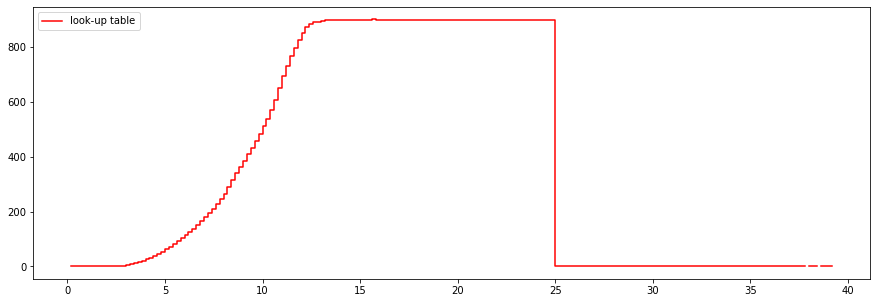

In [10]:
## According to 2nd way

df_17,lutm = get_wind_power_relationship(tt17_mean_data)

demand = get_demand_data()
total_curtailed_energy_2nd, curtailed_power = calculate_curtailed_energy_mean_demand(df_17, demand)

## Q2: function to return the curtailed energy based on the number of household
#### Two assumptions: 1. heating during all years; 2. heating during only winter

In [11]:
# The following step is to define percentage of household use DR system for heating
DR_penetration_perc = 0.1

# Annual energy saving at different curtailment level
def saved_curtailmend_power_AF(DR_penetration_perc):

    # Import resc_heating_usage
    resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')

    # Convert the orignal curtailed table(in minutes) to table(in half hours) 
    curtailed_power_dropna_minute = curtailed_power.dropna()
    curtailed_power_dropna_minute['Timestamp'] = curtailed_power_dropna_minute['Timestamp'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,30*(dt.minute // 30)))
    curtailed_power_dropna_HH = pd.DataFrame(data = curtailed_power_dropna_minute.groupby(['Timestamp'])['power_excess'].mean()).reset_index()
    curtailed_power_dropna_HH['Hour']  = curtailed_power_dropna_HH.Timestamp.dt.hour
    curtailed_power_dropna_HH['Year']  = curtailed_power_dropna_HH.Timestamp.dt.year
    curtailed_power_dropna_HH['Month']  = curtailed_power_dropna_HH.Timestamp.dt.month
    curtailed_power_dropna_HH['Minute']  = curtailed_power_dropna_HH.Timestamp.dt.minute
    curtailed_power_dropna_HH['Day']  = curtailed_power_dropna_HH.Timestamp.dt.day

    # Import Udemand
    Udemand= pd.read_csv('residential_demand.csv')
    Udemand = Udemand.reset_index()
    Udemand.Timestamp = pd.to_datetime(Udemand.Timestamp)
    Udemand['Demand_mean_kw'] = Udemand['Demand_mean_kw'] * 8193/365/24/Udemand.Demand_mean_kw.mean() 
    Udemand['Year']  = Udemand.Timestamp.dt.year
    Udemand=Udemand[Udemand['Year']==2017]
    Udemand['N_households']=orkney_households

    # Find our that in curatiled_power_drop_na_HH, at what timestamps the power_excess is missing, fill them in with 0
    curtailed_power_missing = pd.DataFrame(set(Udemand.Timestamp)-set(curtailed_power_dropna_HH.Timestamp),columns=['Timestamp'])
    curtailed_power_missing['power_excess'] = 0
    curtailed_power_missing['Hour']  = curtailed_power_missing.Timestamp.dt.hour
    curtailed_power_missing['Year']  = curtailed_power_missing.Timestamp.dt.year
    curtailed_power_missing['Month']  = curtailed_power_missing.Timestamp.dt.month
    curtailed_power_missing['Minute']  = curtailed_power_missing.Timestamp.dt.minute
    curtailed_power_missing['Day']  = curtailed_power_missing.Timestamp.dt.day
    curtailed_power_fill_na = pd.concat([curtailed_power_missing,curtailed_power_dropna_HH])

    # Merge the three tables and choose the necessary columns
    combined_table_2 = pd.merge(Udemand,curtailed_power_fill_na, how ='left',on=['Timestamp']).drop(columns=['Year_x']).rename(columns={'Year_y':'Year'})
    combined_table_2 = pd.merge(combined_table_2,resc_heating_usage, how ='left',on=['Hour','Minute']) 
    combined_table_2=combined_table_2[['Timestamp','Demand_mean_kw','N_households','res_heating_perc','power_excess','Year','Month','Hour','Minute']]

    # Calculate the number of households joined in this DR program given the DR_penetration_perc
    DR_penetration_num= orkney_households*DR_penetration_perc
    
    # Calculate additional residential electicity usage by installing DR system
    combined_table_2['N_households']=orkney_households
    combined_table_2['household_with_DR']=DR_penetration_num
    combined_table_2['addi_demand_by_DR_kwh']=0.5*combined_table_2['household_with_DR']*combined_table_2['Demand_mean_kw']*combined_table_2['res_heating_perc']
    combined_table_2

    # Replace negative/NaN saved curtailment energy by 0
    combined_table_2['saved_curtailment_kwh']= combined_table_2[['addi_demand_by_DR_kwh','power_excess']].min(axis=1)
    combined_table_2['saved_curtailment_kwh'] = combined_table_2['saved_curtailment_kwh'].fillna(0)
    
    # Calculate the yearly_saved_energy(mwh)
    yearly_saved_energy_AF = pd.DataFrame(combined_table_2.groupby(['Year'])['saved_curtailment_kwh'].sum())
    
    return yearly_saved_energy_AF

    
    
# Annual energy saving at different curtailment level
def saved_curtailmend_power_seasonal_AF(DR_penetration_perc,DR_month_1,DR_month_2,DR_month_3):

    # Import resc_heating_usage
    resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')

    # Convert the orignal curtailed table(in minutes) to table(in half hours) 
    curtailed_power_dropna_minute = curtailed_power.dropna()
    curtailed_power_dropna_minute['Timestamp'] = curtailed_power_dropna_minute['Timestamp'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,30*(dt.minute // 30)))
    curtailed_power_dropna_HH = pd.DataFrame(data = curtailed_power_dropna_minute.groupby(['Timestamp'])['power_excess'].mean()).reset_index()
    curtailed_power_dropna_HH['Hour']  = curtailed_power_dropna_HH.Timestamp.dt.hour
    curtailed_power_dropna_HH['Year']  = curtailed_power_dropna_HH.Timestamp.dt.year
    curtailed_power_dropna_HH['Month']  = curtailed_power_dropna_HH.Timestamp.dt.month
    curtailed_power_dropna_HH['Minute']  = curtailed_power_dropna_HH.Timestamp.dt.minute
    curtailed_power_dropna_HH['Day']  = curtailed_power_dropna_HH.Timestamp.dt.day

    # Import Udemand
    Udemand= pd.read_csv('residential_demand.csv')
    Udemand = Udemand.reset_index()
    Udemand.Timestamp = pd.to_datetime(Udemand.Timestamp)
    Udemand['Demand_mean_kw'] = Udemand['Demand_mean_kw'] * 8193/365/24/Udemand.Demand_mean_kw.mean() 
    Udemand['Year']  = Udemand.Timestamp.dt.year
    Udemand=Udemand[Udemand['Year']==2017]
    Udemand['N_households']=orkney_households

    # Find our that in curatiled_power_drop_na_HH, at what timestamps the power_excess is missing, fill them in with 0
    curtailed_power_missing = pd.DataFrame(set(Udemand.Timestamp)-set(curtailed_power_dropna_HH.Timestamp),columns=['Timestamp'])
    curtailed_power_missing['power_excess'] = 0
    curtailed_power_missing['Hour']  = curtailed_power_missing.Timestamp.dt.hour
    curtailed_power_missing['Year']  = curtailed_power_missing.Timestamp.dt.year
    curtailed_power_missing['Month']  = curtailed_power_missing.Timestamp.dt.month
    curtailed_power_missing['Minute']  = curtailed_power_missing.Timestamp.dt.minute
    curtailed_power_missing['Day']  = curtailed_power_missing.Timestamp.dt.day
    curtailed_power_fill_na = pd.concat([curtailed_power_missing,curtailed_power_dropna_HH])

    # Merge the three tables and choose the necessary columns
    combined_table_2 = pd.merge(Udemand,curtailed_power_fill_na, how ='left',on=['Timestamp']).drop(columns=['Year_x']).rename(columns={'Year_y':'Year'})
    combined_table_2 = pd.merge(combined_table_2,resc_heating_usage, how ='left',on=['Hour','Minute']) 
    combined_table_2=combined_table_2[['Timestamp','Demand_mean_kw','N_households','res_heating_perc','power_excess','Year','Month','Hour','Minute']]
    combined_table_2=combined_table_2[ (combined_table_2['Month']== DR_month_1) | (combined_table_2['Month']== DR_month_2)  | (combined_table_2['Month']== DR_month_3)  ] 

    # Calculate the number of households joined in this DR program given the DR_penetration_perc
    DR_penetration_num= orkney_households*DR_penetration_perc
    
    # Calculate additional residential electicity usage by installing DR system
    combined_table_2['N_households']=orkney_households
    combined_table_2['household_with_DR']=DR_penetration_num
    combined_table_2['addi_demand_by_DR_kwh']=0.5*combined_table_2['household_with_DR']*combined_table_2['Demand_mean_kw']*combined_table_2['res_heating_perc']
    combined_table_2

    # Replace negative/NaN saved curtailment energy by 0
    combined_table_2['saved_curtailment_kwh']= combined_table_2[['addi_demand_by_DR_kwh','power_excess']].min(axis=1)
    combined_table_2['saved_curtailment_kwh'] = combined_table_2['saved_curtailment_kwh'].fillna(0)
    
    # Calculate the yearly_saved_energy(mwh)
    yearly_saved_energy_AF = pd.DataFrame(combined_table_2.groupby(['Year'])['saved_curtailment_kwh'].sum())
    
    return yearly_saved_energy_AF

# Monthly energy saving at different curtailment level
def saved_curtailmend_power_AF_monthly_Qian(DR_penetration_perc,total_number_household):

    # Import resc_heating_usage
    resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')

    # Convert the orignal curtailed table(in minutes) to table(in half hours) 
    curtailed_power_dropna_minute = curtailed_power.dropna()
    curtailed_power_dropna_minute['Timestamp'] = curtailed_power_dropna_minute['Timestamp'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,30*(dt.minute // 30)))
    curtailed_power_dropna_HH = pd.DataFrame(data = curtailed_power_dropna_minute.groupby(['Timestamp'])['power_excess'].mean()).reset_index()
    curtailed_power_dropna_HH['Hour']  = curtailed_power_dropna_HH.Timestamp.dt.hour
    curtailed_power_dropna_HH['Year']  = curtailed_power_dropna_HH.Timestamp.dt.year
    curtailed_power_dropna_HH['Month']  = curtailed_power_dropna_HH.Timestamp.dt.month
    curtailed_power_dropna_HH['Minute']  = curtailed_power_dropna_HH.Timestamp.dt.minute
    curtailed_power_dropna_HH['Day']  = curtailed_power_dropna_HH.Timestamp.dt.day

    # Import Udemand
    Udemand= pd.read_csv('residential_demand.csv')
    Udemand = Udemand.reset_index()
    Udemand.Timestamp = pd.to_datetime(Udemand.Timestamp)
    Udemand['Demand_mean_kw'] = Udemand['Demand_mean_kw'] * 8193/365/24/Udemand.Demand_mean_kw.mean() 
    Udemand['Year']  = Udemand.Timestamp.dt.year
    Udemand=Udemand[Udemand['Year']==2017]
    Udemand['N_households']=total_number_household

    # Find our that in curatiled_power_drop_na_HH, at what timestamps the power_excess is missing, fill them in with 0
    curtailed_power_missing = pd.DataFrame(set(Udemand.Timestamp)-set(curtailed_power_dropna_HH.Timestamp),columns=['Timestamp'])
    curtailed_power_missing['power_excess'] = 0
    curtailed_power_missing['Hour']  = curtailed_power_missing.Timestamp.dt.hour
    curtailed_power_missing['Year']  = curtailed_power_missing.Timestamp.dt.year
    curtailed_power_missing['Month']  = curtailed_power_missing.Timestamp.dt.month
    curtailed_power_missing['Minute']  = curtailed_power_missing.Timestamp.dt.minute
    curtailed_power_missing['Day']  = curtailed_power_missing.Timestamp.dt.day
    curtailed_power_fill_na = pd.concat([curtailed_power_missing,curtailed_power_dropna_HH])

    # Merge the three tables and choose the necessary columns
    combined_table_2 = pd.merge(Udemand,curtailed_power_fill_na, how ='left',on=['Timestamp']).drop(columns=['Year_x']).rename(columns={'Year_y':'Year'})
    combined_table_2 = pd.merge(combined_table_2,resc_heating_usage, how ='left',on=['Hour','Minute']) 
    combined_table_2=combined_table_2[['Timestamp','Demand_mean_kw','N_households','res_heating_perc','power_excess','Year','Month','Hour','Minute']]

    # Calculate the number of households joined in this DR program given the DR_penetration_perc
    DR_penetration_num= total_number_household*DR_penetration_perc
    
    # Calculate additional residential electicity usage by installing DR system
    combined_table_2['N_households']=total_number_household
    combined_table_2['household_with_DR']=DR_penetration_num
    combined_table_2['addi_demand_by_DR_kwh']=0.5*combined_table_2['household_with_DR']*combined_table_2['Demand_mean_kw']*combined_table_2['res_heating_perc']
    combined_table_2

    # Replace negative/NaN saved curtailment energy by 0
    combined_table_2['saved_curtailment_kwh']= combined_table_2[['addi_demand_by_DR_kwh','power_excess']].min(axis=1)
    combined_table_2['saved_curtailment_kwh'] = combined_table_2['saved_curtailment_kwh'].fillna(0)
    
    # Calculate the yearly_saved_energy(mwh)
    monthly_saved_energy_AF = pd.DataFrame(combined_table_2.groupby(['Month'])['saved_curtailment_kwh'].sum())
    
    return monthly_saved_energy_AF

## Q2: function to draw graph of saved curtailment

No handles with labels found to put in legend.


Text(0.5, 0, 'DR penetration level (index)')

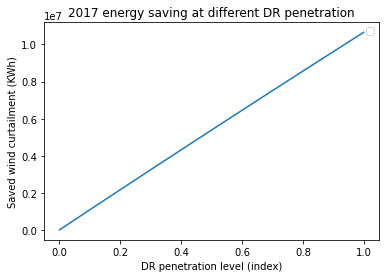

In [12]:
# Draw the graph of different energy saving of different penetration level
#def draw_saved_energy_penetration(start,end):

n=0
saved_energy_of_different_penetration=list()
for i in range(0,11):
    DR_penetration_perc = i/10
    DR_penetration_num= 10000*DR_penetration_perc

    #Print yearly_saved_energy(mwh)
    combined_table_draw_1 = saved_curtailmend_power_AF(DR_penetration_perc)
    yearly_saved_energy = pd.DataFrame(combined_table_draw_1.groupby(['Year'])['saved_curtailment_kwh'].sum())
    val=yearly_saved_energy.iloc[0]['saved_curtailment_kwh']
    saved_energy_of_different_penetration.append(val)


    
# print(saved_energy_of_different_penetration)

x=[round(x*0.1,1) for x in range(0,11)]
y=saved_energy_of_different_penetration
Penetration_graph=plt.plot(x,y)
plt.legend()
plt.title("2017 energy saving at different DR penetration")
plt.ylabel("Saved wind curtailment (KWh)")
plt.xlabel("DR penetration level (index)")



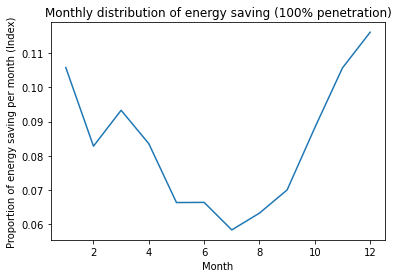

In [13]:
# Draw monthly saved curtailed energy at different penetration
def Monthly_energy_saving(DR_penetration_perc):

    # Import resc_heating_usage
    resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')

    # Convert the orignal curtailed table(in minutes) to table(in half hours) 
    curtailed_power_dropna_minute = curtailed_power.dropna()
    curtailed_power_dropna_minute['Timestamp'] = curtailed_power_dropna_minute['Timestamp'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,30*(dt.minute // 30)))
    curtailed_power_dropna_HH = pd.DataFrame(data = curtailed_power_dropna_minute.groupby(['Timestamp'])['power_excess'].mean()).reset_index()
    curtailed_power_dropna_HH['Hour']  = curtailed_power_dropna_HH.Timestamp.dt.hour
    curtailed_power_dropna_HH['Year']  = curtailed_power_dropna_HH.Timestamp.dt.year
    curtailed_power_dropna_HH['Month']  = curtailed_power_dropna_HH.Timestamp.dt.month
    curtailed_power_dropna_HH['Minute']  = curtailed_power_dropna_HH.Timestamp.dt.minute
    curtailed_power_dropna_HH['Day']  = curtailed_power_dropna_HH.Timestamp.dt.day

    # Import Udemand
    Udemand= pd.read_csv('residential_demand.csv')
    Udemand = Udemand.reset_index()
    Udemand.Timestamp = pd.to_datetime(Udemand.Timestamp)
    Udemand['Demand_mean_kw'] = Udemand['Demand_mean_kw'] * 8193/365/24/Udemand.Demand_mean_kw.mean() 
    Udemand['Year']  = Udemand.Timestamp.dt.year
    Udemand=Udemand[Udemand['Year']==2017]
    Udemand['N_households']=orkney_households

    # Find our that in curatiled_power_drop_na_HH, at what timestamps the power_excess is missing, fill them in with 0
    curtailed_power_missing = pd.DataFrame(set(Udemand.Timestamp)-set(curtailed_power_dropna_HH.Timestamp),columns=['Timestamp'])
    curtailed_power_missing['power_excess'] = 0
    curtailed_power_missing['Hour']  = curtailed_power_missing.Timestamp.dt.hour
    curtailed_power_missing['Year']  = curtailed_power_missing.Timestamp.dt.year
    curtailed_power_missing['Month']  = curtailed_power_missing.Timestamp.dt.month
    curtailed_power_missing['Minute']  = curtailed_power_missing.Timestamp.dt.minute
    curtailed_power_missing['Day']  = curtailed_power_missing.Timestamp.dt.day
    curtailed_power_fill_na = pd.concat([curtailed_power_missing,curtailed_power_dropna_HH])

    # Merge the three tables and choose the necessary columns
    combined_table_2 = pd.merge(Udemand,curtailed_power_fill_na, how ='left',on=['Timestamp']).drop(columns=['Year_x']).rename(columns={'Year_y':'Year'})
    combined_table_2 = pd.merge(combined_table_2,resc_heating_usage, how ='left',on=['Hour','Minute']) 
    combined_table_2=combined_table_2[['Timestamp','Demand_mean_kw','N_households','res_heating_perc','power_excess','Year','Month','Hour','Minute']]

    # Calculate the number of households joined in this DR program given the DR_penetration_perc
    DR_penetration_num= orkney_households*DR_penetration_perc
    
    # Calculate additional residential electicity usage by installing DR system
    combined_table_2['N_households']=orkney_households
    combined_table_2['household_with_DR']=DR_penetration_num
    combined_table_2['addi_demand_by_DR_kwh']=0.5*combined_table_2['household_with_DR']*combined_table_2['Demand_mean_kw']*combined_table_2['res_heating_perc']
    combined_table_2

    # Replace negative/NaN saved curtailment energy by 0
    combined_table_2['saved_curtailment_kwh']= combined_table_2[['addi_demand_by_DR_kwh','power_excess']].min(axis=1)
    combined_table_2['saved_curtailment_kwh'] = combined_table_2['saved_curtailment_kwh'].fillna(0)
    

    #Print yearly_saved_energy(mwh)
    Monthly_energy_saving = pd.DataFrame(combined_table_2.groupby(['Month'])['saved_curtailment_kwh'].sum())
    x = Monthly_energy_saving.index.values
    y1 = Monthly_energy_saving['saved_curtailment_kwh']/Monthly_energy_saving['saved_curtailment_kwh'].sum()
    


    plt.plot(x,y1,label='2017 saved curtailed energy at each month')
    plt.title("Monthly distribution of energy saving (100% penetration)")
    plt.ylabel("Proportion of energy saving per month (Index)")
    plt.xlabel("Month")
    
Monthly_energy_saving(1)

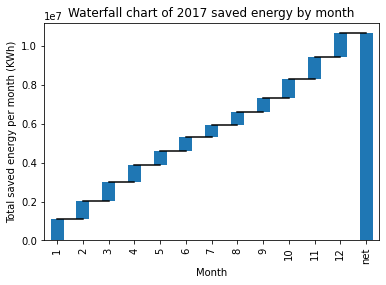

In [14]:


#convert above graph to waterfall breakdown

from IPython.display import display

def Monthly_waterfall_graph(DR_penetration_perc):
    # import new dataset

    # Import resc_heating_usage
    resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')

    # Convert the orignal curtailed table(in minutes) to table(in half hours) 
    curtailed_power_dropna_minute = curtailed_power.dropna()
    curtailed_power_dropna_minute['Timestamp'] = curtailed_power_dropna_minute['Timestamp'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,30*(dt.minute // 30)))
    curtailed_power_dropna_HH = pd.DataFrame(data = curtailed_power_dropna_minute.groupby(['Timestamp'])['power_excess'].mean()).reset_index()
    curtailed_power_dropna_HH['Hour']  = curtailed_power_dropna_HH.Timestamp.dt.hour
    curtailed_power_dropna_HH['Year']  = curtailed_power_dropna_HH.Timestamp.dt.year
    curtailed_power_dropna_HH['Month']  = curtailed_power_dropna_HH.Timestamp.dt.month
    curtailed_power_dropna_HH['Minute']  = curtailed_power_dropna_HH.Timestamp.dt.minute
    curtailed_power_dropna_HH['Day']  = curtailed_power_dropna_HH.Timestamp.dt.day

    # Import Udemand
    Udemand= pd.read_csv('residential_demand.csv')
    Udemand = Udemand.reset_index()
    Udemand.Timestamp = pd.to_datetime(Udemand.Timestamp)
    Udemand['Demand_mean_kw'] = Udemand['Demand_mean_kw'] * 8193/365/24/Udemand.Demand_mean_kw.mean() 
    Udemand['Year']  = Udemand.Timestamp.dt.year
    Udemand=Udemand[Udemand['Year']==2017]
    Udemand['N_households']=orkney_households

    # Find our that in curatiled_power_drop_na_HH, at what timestamps the power_excess is missing, fill them in with 0
    curtailed_power_missing = pd.DataFrame(set(Udemand.Timestamp)-set(curtailed_power_dropna_HH.Timestamp),columns=['Timestamp'])
    curtailed_power_missing['power_excess'] = 0
    curtailed_power_missing['Hour']  = curtailed_power_missing.Timestamp.dt.hour
    curtailed_power_missing['Year']  = curtailed_power_missing.Timestamp.dt.year
    curtailed_power_missing['Month']  = curtailed_power_missing.Timestamp.dt.month
    curtailed_power_missing['Minute']  = curtailed_power_missing.Timestamp.dt.minute
    curtailed_power_missing['Day']  = curtailed_power_missing.Timestamp.dt.day
    curtailed_power_fill_na = pd.concat([curtailed_power_missing,curtailed_power_dropna_HH])

    # Merge the three tables and choose the necessary columns
    combined_table_2 = pd.merge(Udemand,curtailed_power_fill_na, how ='left',on=['Timestamp']).drop(columns=['Year_x']).rename(columns={'Year_y':'Year'})
    combined_table_2 = pd.merge(combined_table_2,resc_heating_usage, how ='left',on=['Hour','Minute']) 
    combined_table_2=combined_table_2[['Timestamp','Demand_mean_kw','N_households','res_heating_perc','power_excess','Year','Month','Hour','Minute']]

    # Calculate the number of households joined in this DR program given the DR_penetration_perc
    DR_penetration_num= orkney_households*DR_penetration_perc
    
    # Calculate additional residential electicity usage by installing DR system
    combined_table_2['N_households']=orkney_households
    combined_table_2['household_with_DR']=DR_penetration_num
    combined_table_2['addi_demand_by_DR_kwh']=0.5*combined_table_2['household_with_DR']*combined_table_2['Demand_mean_kw']*combined_table_2['res_heating_perc']
    combined_table_2

    # Replace negative/NaN saved curtailment energy by 0
    combined_table_2['saved_curtailment_kwh']= combined_table_2[['addi_demand_by_DR_kwh','power_excess']].min(axis=1)
    combined_table_2['saved_curtailment_kwh'] = combined_table_2['saved_curtailment_kwh'].fillna(0)
 
    #Print yearly_saved_energy(mwh)
    combined_table_draw_month = pd.DataFrame(combined_table_2.groupby(['Month'])['saved_curtailment_kwh'].sum())
    Index = combined_table_draw_month.index.values
    data = combined_table_draw_month['saved_curtailment_kwh']

    blank=combined_table_draw_month.saved_curtailment_kwh.cumsum().shift(1).fillna(0)

    total = combined_table_draw_month.sum().saved_curtailment_kwh
    combined_table_draw_month.loc["net"] = total
    blank.loc["net"] = total


    step = blank.reset_index(drop=True).repeat(3).shift(-1)
    step[1::3] = np.nan

    blank.loc["net"] = 0

    my_plot = combined_table_draw_month.plot(kind='bar', stacked=True, bottom=blank,legend=None, title="Waterfall chart of 2017 saved energy by month")
    my_plot.plot(step.index, step.values,'k')
    plt.ylabel("Total saved energy per month (KWh)")



Monthly_waterfall_graph(1)



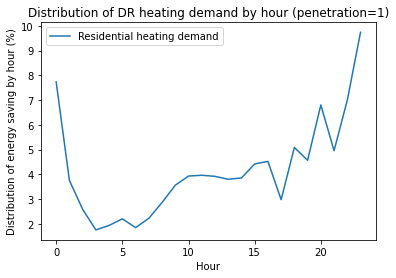

In [15]:
def Hourly_waterfall_demand(DR_penetration_perc):


    # Import resc_heating_usage
    resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')

    # Convert the orignal curtailed table(in minutes) to table(in half hours) 
    curtailed_power_dropna_minute = curtailed_power.dropna()
    curtailed_power_dropna_minute['Timestamp'] = curtailed_power_dropna_minute['Timestamp'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,30*(dt.minute // 30)))
    curtailed_power_dropna_HH = pd.DataFrame(data = curtailed_power_dropna_minute.groupby(['Timestamp'])['power_excess'].mean()).reset_index()
    curtailed_power_dropna_HH['Hour']  = curtailed_power_dropna_HH.Timestamp.dt.hour
    curtailed_power_dropna_HH['Year']  = curtailed_power_dropna_HH.Timestamp.dt.year
    curtailed_power_dropna_HH['Month']  = curtailed_power_dropna_HH.Timestamp.dt.month
    curtailed_power_dropna_HH['Minute']  = curtailed_power_dropna_HH.Timestamp.dt.minute
    curtailed_power_dropna_HH['Day']  = curtailed_power_dropna_HH.Timestamp.dt.day

    # Import Udemand
    Udemand= pd.read_csv('residential_demand.csv')
    Udemand = Udemand.reset_index()
    Udemand.Timestamp = pd.to_datetime(Udemand.Timestamp)
    Udemand['Demand_mean_kw'] = Udemand['Demand_mean_kw'] * 8193/365/24/Udemand.Demand_mean_kw.mean() 
    Udemand['Year']  = Udemand.Timestamp.dt.year
    Udemand=Udemand[Udemand['Year']==2017]
    Udemand['N_households']=orkney_households

    # Find our that in curatiled_power_drop_na_HH, at what timestamps the power_excess is missing, fill them in with 0
    curtailed_power_missing = pd.DataFrame(set(Udemand.Timestamp)-set(curtailed_power_dropna_HH.Timestamp),columns=['Timestamp'])
    curtailed_power_missing['power_excess'] = 0
    curtailed_power_missing['Hour']  = curtailed_power_missing.Timestamp.dt.hour
    curtailed_power_missing['Year']  = curtailed_power_missing.Timestamp.dt.year
    curtailed_power_missing['Month']  = curtailed_power_missing.Timestamp.dt.month
    curtailed_power_missing['Minute']  = curtailed_power_missing.Timestamp.dt.minute
    curtailed_power_missing['Day']  = curtailed_power_missing.Timestamp.dt.day
    curtailed_power_fill_na = pd.concat([curtailed_power_missing,curtailed_power_dropna_HH])

    # Merge the three tables and choose the necessary columns
    combined_table_2 = pd.merge(Udemand,curtailed_power_fill_na, how ='left',on=['Timestamp']).drop(columns=['Year_x']).rename(columns={'Year_y':'Year'})
    combined_table_2 = pd.merge(combined_table_2,resc_heating_usage, how ='left',on=['Hour','Minute']) 
    combined_table_2=combined_table_2[['Timestamp','Demand_mean_kw','N_households','res_heating_perc','power_excess','Year','Month','Hour','Minute']]

    # Calculate the number of households joined in this DR program given the DR_penetration_perc
    DR_penetration_num= orkney_households*DR_penetration_perc
    
    # Calculate additional residential electicity usage by installing DR system
    combined_table_2['N_households']=orkney_households
    combined_table_2['household_with_DR']=DR_penetration_num
    combined_table_2['addi_demand_by_DR_kwh']=0.5*combined_table_2['household_with_DR']*combined_table_2['Demand_mean_kw']*combined_table_2['res_heating_perc']
    combined_table_2

    # Replace negative/NaN saved curtailment energy by 0
    combined_table_2['saved_curtailment_kwh']= combined_table_2[['addi_demand_by_DR_kwh','power_excess']].min(axis=1)
    combined_table_2['saved_curtailment_kwh'] = combined_table_2['saved_curtailment_kwh'].fillna(0)    
    
    
    #Print yearly_saved_energy(mwh)
    Hourly_DR_demand = pd.DataFrame(combined_table_2.groupby(['Hour'])['addi_demand_by_DR_kwh'].sum())
    x = Hourly_DR_demand.index.values
    y1 = 100*Hourly_DR_demand['addi_demand_by_DR_kwh']/Hourly_DR_demand['addi_demand_by_DR_kwh'].sum()

    plt.plot(x,y1,label='Residential heating demand')
    plt.title("Distribution of DR heating demand by hour (penetration=1)")
    plt.ylabel("Distribution of energy saving by hour (%)")
    plt.xlabel("Hour")
    plt.legend()

Hourly_waterfall_demand(1)
    


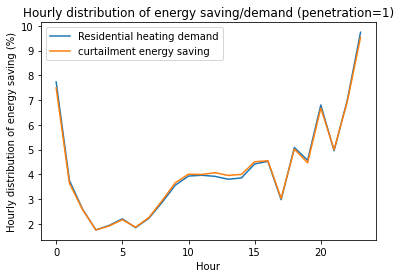

In [16]:
def Hourly_waterfall_graph_combined(DR_penetration_perc):
    # import new dataset

    # Import resc_heating_usage
    resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')

    # Convert the orignal curtailed table(in minutes) to table(in half hours) 
    curtailed_power_dropna_minute = curtailed_power.dropna()
    curtailed_power_dropna_minute['Timestamp'] = curtailed_power_dropna_minute['Timestamp'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,30*(dt.minute // 30)))
    curtailed_power_dropna_HH = pd.DataFrame(data = curtailed_power_dropna_minute.groupby(['Timestamp'])['power_excess'].mean()).reset_index()
    curtailed_power_dropna_HH['Hour']  = curtailed_power_dropna_HH.Timestamp.dt.hour
    curtailed_power_dropna_HH['Year']  = curtailed_power_dropna_HH.Timestamp.dt.year
    curtailed_power_dropna_HH['Month']  = curtailed_power_dropna_HH.Timestamp.dt.month
    curtailed_power_dropna_HH['Minute']  = curtailed_power_dropna_HH.Timestamp.dt.minute
    curtailed_power_dropna_HH['Day']  = curtailed_power_dropna_HH.Timestamp.dt.day

    # Import Udemand
    Udemand= pd.read_csv('residential_demand.csv')
    Udemand = Udemand.reset_index()
    Udemand.Timestamp = pd.to_datetime(Udemand.Timestamp)
    Udemand['Demand_mean_kw'] = Udemand['Demand_mean_kw'] * 8193/365/24/Udemand.Demand_mean_kw.mean() 
    Udemand['Year']  = Udemand.Timestamp.dt.year
    Udemand=Udemand[Udemand['Year']==2017]
    Udemand['N_households']=orkney_households

    # Find our that in curatiled_power_drop_na_HH, at what timestamps the power_excess is missing, fill them in with 0
    curtailed_power_missing = pd.DataFrame(set(Udemand.Timestamp)-set(curtailed_power_dropna_HH.Timestamp),columns=['Timestamp'])
    curtailed_power_missing['power_excess'] = 0
    curtailed_power_missing['Hour']  = curtailed_power_missing.Timestamp.dt.hour
    curtailed_power_missing['Year']  = curtailed_power_missing.Timestamp.dt.year
    curtailed_power_missing['Month']  = curtailed_power_missing.Timestamp.dt.month
    curtailed_power_missing['Minute']  = curtailed_power_missing.Timestamp.dt.minute
    curtailed_power_missing['Day']  = curtailed_power_missing.Timestamp.dt.day
    curtailed_power_fill_na = pd.concat([curtailed_power_missing,curtailed_power_dropna_HH])

    # Merge the three tables and choose the necessary columns
    combined_table_2 = pd.merge(Udemand,curtailed_power_fill_na, how ='left',on=['Timestamp']).drop(columns=['Year_x']).rename(columns={'Year_y':'Year'})
    combined_table_2 = pd.merge(combined_table_2,resc_heating_usage, how ='left',on=['Hour','Minute']) 
    combined_table_2=combined_table_2[['Timestamp','Demand_mean_kw','N_households','res_heating_perc','power_excess','Year','Month','Hour','Minute']]

    # Calculate the number of households joined in this DR program given the DR_penetration_perc
    DR_penetration_num= orkney_households*DR_penetration_perc
    
    # Calculate additional residential electicity usage by installing DR system
    combined_table_2['N_households']=orkney_households
    combined_table_2['household_with_DR']=DR_penetration_num
    combined_table_2['addi_demand_by_DR_kwh']=0.5*combined_table_2['household_with_DR']*combined_table_2['Demand_mean_kw']*combined_table_2['res_heating_perc']
    combined_table_2

    # Replace negative/NaN saved curtailment energy by 0
    combined_table_2['saved_curtailment_kwh']= combined_table_2[['addi_demand_by_DR_kwh','power_excess']].min(axis=1)
    combined_table_2['saved_curtailment_kwh'] = combined_table_2['saved_curtailment_kwh'].fillna(0)    
   

    #Print yearly_saved_energy(mwh)
    yearly_saved_energy_AF_hourly = pd.DataFrame(combined_table_2.groupby(['Hour'])['saved_curtailment_kwh'].sum())
    x = yearly_saved_energy_AF_hourly.index.values
    y1 = 100*yearly_saved_energy_AF_hourly['saved_curtailment_kwh']/yearly_saved_energy_AF_hourly['saved_curtailment_kwh'].sum()

    plt.plot(x,y1,label='curtailment energy saving')
    plt.title("Hourly distribution of energy saving/demand (penetration=1)")
    plt.ylabel("Hourly distribution of energy saving (%)")
    plt.xlabel("Hour")
    plt.legend()

    
    
Hourly_waterfall_demand(1)
Hourly_waterfall_graph_combined(1)


# Q3: function for NPV analysis

In [37]:
total_number_household = 10385
discount_rate = 0.25
P1 = 56/1000
            # The unit is (GBP/KWh)
            # the wholesale price is the generator sells the energy in the general market (based on online data)

P2 = 0.05 # The unit is (GBP/KWh)
            # There is the gas price which the local residents are used for heating
            # https://www.thegreenage.co.uk/cheaper-heat-home-gas-electricity/
P3 = 60/1000 # The unit is (GBP/KWh)
            # This is the electricity price that the local residents will use for heating  
            # https://www.thegreenage.co.uk/cheaper-heat-home-gas-electricity/

FC = 100 # The unit is (GBP/Household)
         # the installment cost of this DR program 
VC = 1 # The unit is (GBP/month * household） 

In [115]:
def return_wholesale_price():
    col_list = ['YEAR','MONTH', 'WHOLESALE PRICE(￡/MWh）']
    wholesale_price = pd.read_csv('wholesale_price.csv',usecols=col_list) # https://www.businesselectricityprices.org.uk/retail-versus-wholesale-prices/
    wholesale_price['Cumulative_Month'] = wholesale_price.index.values + 1
    return wholesale_price

def return_Revenue_for_generator(n,p_energy,P1): 
    return p_energy*P1

def return_Loss_for_all_household(p_energy,P3,P2):
    return p_energy*(P2-P3)
    
def return_degree_of_penetration(year_index,total_number_household,ideal_penetration,type_of_growth):

    if type_of_growth == 'L':
        x_list = np.arange(0.1, 1.1, 0.1).tolist()
    elif type_of_growth == 'E':
        x_list = [1-np.exp(-x)for x in np.arange(0.1, 3.1, 0.3).tolist()]
        
    y_list = [x*total_number_household*ideal_penetration for x in x_list]
    percentage_degree = x_list[year_index]
    cumulative_number_of_household = y_list[year_index]
    return percentage_degree,cumulative_number_of_household

In [116]:
def return_Net_Cash_flow_Kaluza(year_index,ideal_penetration,total_number_household,type_of_growth):
        
    percentage_degree,cumulative_number_of_household = return_degree_of_penetration(year_index,total_number_household,ideal_penetration,type_of_growth)
    
    monthly_saved_energy = saved_curtailmend_power_AF_monthly_Qian(percentage_degree,total_number_household).reset_index()
    p_energy = monthly_saved_energy.saved_curtailment_kwh * ideal_penetration
    monthly_saved_energy['saved_curtailment_kwh'] = p_energy
    month = monthly_saved_energy.Month.unique()
    
    table_Q2 = pd.DataFrame(data = month,columns=['Month']).set_index('Month')
    table_Q2 = pd.merge(table_Q2,monthly_saved_energy,how='inner',on=['Month'])
    table_Q2['year_index'] = year_index
    table_Q2['n'] = total_number_household*ideal_penetration*0.1*(year_index+1)
    table_Q2['New_Installment'] = 0
    table_Q2['New_Installment'].iloc._setitem_with_indexer(0,total_number_household*ideal_penetration*0.1)
    table_Q2['P1(￡/KWh)'] = P1
    table_Q2['P3(￡/KWh)'] = P3
    table_Q2['P2(￡/KWh)'] = P2
    table_Q2['FC(￡)'] = FC
    table_Q2['VC(￡)'] = VC
    table_Q2['Revenue_Generator'] = table_Q2.apply(lambda row:return_Revenue_for_generator(row['n'],row['saved_curtailment_kwh'],row['P1(￡/KWh)']),axis=1)
    table_Q2['Loss_All_Household'] = table_Q2.apply(lambda row:return_Loss_for_all_household(row['saved_curtailment_kwh'],row['P3(￡/KWh)'],row['P2(￡/KWh)']),axis=1)
    table_Q2['Revenue_minus_Loss'] = table_Q2['Revenue_Generator'] + table_Q2['Loss_All_Household']
    table_Q2['Net_Income_for_Generator'] = table_Q2['Revenue_minus_Loss']/10*1
    table_Q2['Net_Income_for_Kaluza'] = table_Q2['Revenue_minus_Loss']/10*9
    table_Q2['Fixed_Cost_Kaluza'] = table_Q2['New_Installment']*100*1.2
    table_Q2['Variable_Cost_Kaluza'] = VC * table_Q2['n']
    table_Q2['Total_cost_Kaluza'] = table_Q2['Fixed_Cost_Kaluza'] + table_Q2['Variable_Cost_Kaluza']
    table_Q2['Net_Cash_flow_Kaluza'] = table_Q2['Net_Income_for_Kaluza'] - table_Q2['Total_cost_Kaluza']
    return table_Q2

In [117]:
def add_NPV(table):
    def return_npv(month,value):
        monthly_discount_rate = 0.07/12
        return value/(1+monthly_discount_rate)**(month-1)
    table['Discounted_cash_flow'] = table.apply(lambda row: return_npv(row.Month,row.Net_Cash_flow_Kaluza),axis=1)
    table['NPV'] = table['Discounted_cash_flow'].cumsum()
    return table

In [118]:
def return_yearly_revenue_based_on_ideal_pentration(ideal_penetration,total_number_household,type_of_growth):
    years_list = list(range(0,10))
    total_cash_flow_list = [return_Net_Cash_flow_Kaluza(year_index,ideal_penetration,total_number_household,type_of_growth) for year_index in years_list]
    total_cash_flow_model = pd.concat(total_cash_flow_list).reset_index().drop(columns=['index','P1(￡/KWh)','P2(￡/KWh)','P3(￡/KWh)','FC(￡)','VC(￡)'])
    NPV_model = add_NPV(total_cash_flow_model)
    yearly_revenue = NPV_model.groupby(['year_index'])['Discounted_cash_flow'].sum()
    cumulative_cash_flow = yearly_revenue.cumsum()/1000
    return total_cash_flow_model,cumulative_cash_flow,years_list

In [119]:
def datetime_positive_NPV(total_cash_flow_model):
    Month =  total_cash_flow_model[ total_cash_flow_model.NPV >= 0].iloc[0].Month
    Year =  total_cash_flow_model[ total_cash_flow_model.NPV >= 0].iloc[0].year_index
    return int(Month),int(Year)

In [135]:
def plot_Discounted_Cash_Flow_in_3_degree_Assumptions(type_of_growth):
    total_cash_flow_model_90,cumulative_cash_flow_list_90,years_list = return_yearly_revenue_based_on_ideal_pentration(0.9,total_number_household,type_of_growth)
    total_cash_flow_model_75,cumulative_cash_flow_list_75,years_list = return_yearly_revenue_based_on_ideal_pentration(0.75,total_number_household,type_of_growth)
    total_cash_flow_model_50,cumulative_cash_flow_list_50,years_list = return_yearly_revenue_based_on_ideal_pentration(0.5,total_number_household,type_of_growth)
    Month_1,Year_1 = datetime_positive_NPV(total_cash_flow_model_90)
    Month_2,Year_2 = datetime_positive_NPV(total_cash_flow_model_75)
    Month_3,Year_3 = datetime_positive_NPV(total_cash_flow_model_50)
    Average_Month = (Month_1+Month_2+Month_3)/3
    Average_Year = (Year_1+Year_2+Year_3)/3
    total_Month = Average_Year*12 + Average_Month
    
          
    years_list_updated = [years + 1 for years in years_list] 
    plt.plot(years_list_updated,cumulative_cash_flow_list_90,'-',label='Final degree of penetration: 90%')
    plt.plot(years_list_updated,cumulative_cash_flow_list_75,'--',label='Final degree of penetration: 75%')
    plt.plot(years_list_updated,cumulative_cash_flow_list_50,'-.',label='Final degree of penetration: 50%')
    plt.xlabel('Year')
    plt.ylabel('Discount cash flow(K)')
    plt.legend()
    if type_of_growth == 'L':
        plt.title("Cumulative Discounted Cash Flow in Assumptions of Degree of Penetration(Linear Distribution)")
        print('If the degree of penetration follows linear distribution, the total months required to make a positive NPV is',int(total_Month))
    elif type_of_growth == 'E':
        plt.title("Cumulative Discounted Cash Flow in Assumptions of Degree of Penetration(Exponential Distribution)")
        print('If the degree of penetration follows exponential distribution, the total months required to make a positive NPV is',int(total_Month))

If the degree of penetration follows linear distribution, the total months required to make a positive NPV is 91


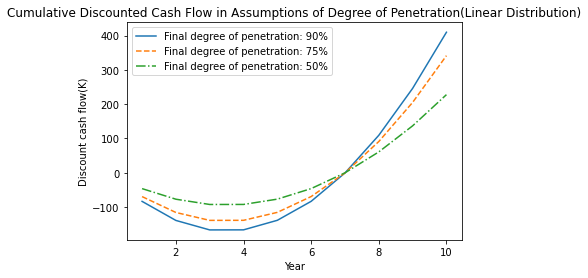

In [136]:
plot_Discounted_Cash_Flow_in_3_degree_Assumptions('L')

If the degree of penetration follows exponential distribution, the total months required to make a positive NPV is 46


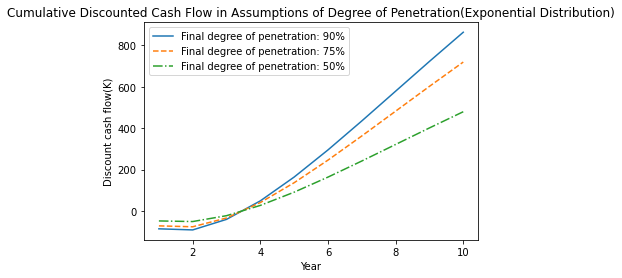

In [137]:
plot_Discounted_Cash_Flow_in_3_degree_Assumptions('E')